# Problem Description
Feature selection is an important topic in DM. Instead of giving lectures on the topic, I like to let you get familiar with this topic by working on the issue using two different approaches, which are considered here.
In a disease study, we typically contrast and compare a group of disease subjects against a group of normal controls in order to find a set of genes that are correlated to the disease phenotypes.  So for this type of problems, we are dealing with two class problems.
Here we consider the problem of finding critical genes whose aberrant regulation (or expression) may lead to Alzheimer’s disease, the most devastating dementia in the aging population. 

AD dataset – Download AD.zip file from the Resources page (under the General Resources tag) on the course piazza website. This is a real dataset of more than 8000 genes of 176 patients of Alzheimer’s disease (in text file case.gex) and 188 age-matched normal people, or controls (in text file ctrl.gex).  You may load them into MS Excel to have a better view. If you want know how these data were collected and used in a disease study, see the original paper: http://www.sciencedirect.com/science/article/pii/S0002929709001086. 

Due to possible memory issue, we will use the first **1800 genes** for each of the two datasets for all 3 problems in this HW (including one in Part 2, which will be assigned later).  


### 0.1 Lest's take a look at data
Your first step is to perform an initial study (or inspection) of the given samples (not the test cases), which may include a brief analysis of the distribution of the samples over one attribute or other properties you think that are worthwhile to exam.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline

# Load the positive data
case = pd.read_csv('AD/case.gex',sep="\t", index_col=0)


#We are going to look at only the first 1800 genes
case = case.T

# Data Profile
print " Case.gex has {} data points with {} variables each.".format(*case.shape)

 Case.gex has 176 data points with 8561 variables each.


In [4]:
# Load the negative data 
# ctrl = pd.read_csv('AD/ctrl.gex',sep=" ")
ctrl = pd.read_table('AD/ctrl.gex', delim_whitespace=True,index_col= 0)


#We are going to look at only the first 1800 genes
ctrl = ctrl.T

print "Ctrl.gex has {} data points with {} variables each.".format(*ctrl.shape)

Ctrl.gex has 188 data points with 8561 variables each.


### 0.2 Let's set up training data
Using the control data as the positive and negative training data (no test data) to build the following RFs, each of which has 500 trees. Compute the frequency of each gene appearing in each of the following RFs.

In [9]:
#we only work on the first 1800 genes
case = case.iloc[:,0:1801]
ctrl = ctrl.iloc[:,0:1801]

# combine case and ctrl files
frames = [case, ctrl]
train = pd.concat(frames)
train = train.convert_objects(convert_numeric=True)
print "Training data has {} data points with {} variables each.".format(*train.shape)
train.head(n=2)

/Users/Chen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Training data has 364 data points with 1801 variables each.


Arrays,Classes,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,...,GI_21265087-S,GI_21265090-S,GI_21265092-S,GI_21265095-S,GI_21265103-S,GI_21265115-S,GI_21265128-A,GI_21269863-S,GI_21269867-S,GI_21269871-A
WGAAD1,2.0,0.459128,0.037793,-0.005021,0.396483,0.294007,0.264442,0.435411,-0.535314,0.160456,...,-0.187465,0.078973,0.016502,0.074084,0.462344,-0.493317,-0.543947,NaN,-0.270062,-0.375547
WGAAD2,2.0,-1.984835,NaN,0.076412,NaN,-0.165882,0.422382,-0.248215,1.018655,-0.348808,...,0.161231,-0.770899,0.220652,NaN,-2.205653,0.094891,0.574672,NaN,0.228154,0.217560


In [275]:
train.tail(n=2)

Arrays,Classes,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,...,GI_21265087-S,GI_21265090-S,GI_21265092-S,GI_21265095-S,GI_21265103-S,GI_21265115-S,GI_21265128-A,GI_21269863-S,GI_21269867-S,GI_21269871-A
WGACON187,1.0,-0.374253,0.326193,0.037210,0.249707,-0.002965,-0.605046,-0.190159,0.232389,0.021765,...,0.690462,0.631325,-0.142041,0.143616,-0.092720,0.081691,-0.264953,0.036088,-0.579048,-0.060903
WGACON188,1.0,-0.107157,-0.353432,-0.043448,0.133230,0.335215,-0.707830,0.227489,0.238576,-0.258214,...,0.254287,0.048133,0.031736,-0.218935,-0.207646,0.106667,0.161404,-0.181574,-0.194495,-0.037419


### 0.3 Preprocess Missing data 
There are many options we could consider when replacing a missing value, for example:
* A constant value that has meaning within the domain, such as 0, distinct from all other values.
* A value from another randomly selected record.
* A mean, median or mode value for the column.
* A value estimated by another predictive model.
Any imputing performed on the training dataset will have to be performed on new data in the future when predictions are needed from the finalized model. This needs to be taken into consideration when choosing how to impute the missing values.

reference: https://machinelearningmastery.com/handle-missing-data-python/

For this homework, I am going to try three ways of imputing missing values to see which one gives better performance. Please see the change for WGAAD2 data point's GI_10047093-S feature (Originally it was NaN) as an example in the following tables.

The model performance is given by model's out of bag(OOB) error provided by sklearn.ensemble.RandomForestClassifier API. It is an analogous of .score method, which returns accuracy of the model. And It simply generalizes to the oob scenario. 

#### 0.3.1 Replace Missing data with 0

In [276]:
# replace missing values with 0
train_NA_as_zero = train.fillna(0)
train_NA_as_zero.to_csv("train_replaceNAwith0.csv")
train_NA_as_zero.head(n=2)

Arrays,Classes,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,...,GI_21265087-S,GI_21265090-S,GI_21265092-S,GI_21265095-S,GI_21265103-S,GI_21265115-S,GI_21265128-A,GI_21269863-S,GI_21269867-S,GI_21269871-A
WGAAD1,2.0,0.459128,0.037793,-0.005021,0.396483,0.294007,0.264442,0.435411,-0.535314,0.160456,...,-0.187465,0.078973,0.016502,0.074084,0.462344,-0.493317,-0.543947,0.0,-0.270062,-0.375547
WGAAD2,2.0,-1.984835,0.000000,0.076412,0.000000,-0.165882,0.422382,-0.248215,1.018655,-0.348808,...,0.161231,-0.770899,0.220652,0.000000,-2.205653,0.094891,0.574672,0.0,0.228154,0.217560


In [277]:
train_y = train_NA_as_zero['Classes'];
train_X = train_NA_as_zero.iloc[:,1:];
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(bootstrap = True, 
                                n_estimators = 500, 
                                max_features =  0.7,
                                min_samples_split = 0.7)
forest = forest.fit(train_X,train_y)

In [278]:
score = forest.oob_score
print "After replacing NaN with 0, score of the training dataset obtained using an out-of-bag estimate is {:,.2f}".format(score)

After replacing NaN with 0, score of the training dataset obtained using an out-of-bag estimate is 0.00


#### 0.3.2 Replace Missing data with mean for the column

In [279]:
from sklearn.preprocessing import Imputer
# Create an imputer object that looks for 'Nan' values, then replaces them with the mean value of the feature by columns (axis=0)
imputer1 = Imputer(missing_values='NaN', strategy='mean', axis=0)
train_NA_as_mean = imputer1.fit_transform(train)
train_NA_as_mean = pd.DataFrame(data = train_NA_as_mean, index = train.index, columns = train.columns)
train_NA_as_mean.to_csv("train_replaceNAwithMean.csv")
train_NA_as_mean.head(n=2)

Arrays,Classes,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,...,GI_21265087-S,GI_21265090-S,GI_21265092-S,GI_21265095-S,GI_21265103-S,GI_21265115-S,GI_21265128-A,GI_21269863-S,GI_21269867-S,GI_21269871-A
WGAAD1,2.0,0.459128,3.779276e-02,-0.005021,3.964832e-01,0.294007,0.264442,0.435411,-0.535314,0.160456,...,-0.187465,0.078973,0.016502,7.408445e-02,0.462344,-0.493317,-0.543947,5.747127e-12,-0.270062,-0.375547
WGAAD2,2.0,-1.984835,-5.571025e-12,0.076412,-1.159420e-11,-0.165882,0.422382,-0.248215,1.018655,-0.348808,...,0.161231,-0.770899,0.220652,-6.116206e-12,-2.205653,0.094891,0.574672,5.747127e-12,0.228154,0.217560


In [280]:
train_y = train_NA_as_mean['Classes'];
train_X = train_NA_as_mean.iloc[:,1:];
forest = RandomForestClassifier(bootstrap = True, 
                                n_estimators = 500, 
                                max_features =  0.7,
                                min_samples_split = 0.7)
forest = forest.fit(train_X,train_y)

In [281]:
score = forest.oob_score
print "After replacing NaN with 0, score of the training dataset obtained using an out-of-bag estimate is {:,.2f}".format(score)

After replacing NaN with 0, score of the training dataset obtained using an out-of-bag estimate is 0.00


#### 0.3.3 Replace Missing data with median for the column

In [282]:
# Create an imputer object that looks for 'Nan' values, then replaces them with the median value of the feature by columns (axis=0)
imputer2 = Imputer(missing_values='NaN', strategy='median', axis=0)
train_NA_as_median = imputer2.fit_transform(train)

train_NA_as_median = pd.DataFrame(train_NA_as_median)
values = list(train['Classes'])
train_NA_as_median.insert(0, "Classes", values)

train_NA_as_median.columns = train.columns
train_NA_as_median.index = train.index
train_NA_as_median.to_csv("train_replaceNAwithMedian.csv")
train_NA_as_median.head(n=2)

/Users/Chen/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/imputation.py:307: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  median[np.ma.getmask(median_masked)] = np.nan


Arrays,Classes,GI_10047091-S,GI_10047093-S,GI_10047103-S,GI_10047133-A,GI_10092596-S,GI_10092600-S,GI_10092616-S,GI_10092618-S,GI_10092672-S,...,GI_21265087-S,GI_21265090-S,GI_21265092-S,GI_21265095-S,GI_21265103-S,GI_21265115-S,GI_21265128-A,GI_21269863-S,GI_21269867-S,GI_21269871-A
WGAAD1,2.0,0.459128,0.037793,-0.005021,0.396483,0.294007,0.264442,0.435411,-0.535314,0.160456,...,-0.187465,0.078973,0.016502,0.074084,0.462344,-0.493317,-0.543947,0.01503,-0.270062,-0.375547
WGAAD2,2.0,-1.984835,0.004726,0.076412,0.048038,-0.165882,0.422382,-0.248215,1.018655,-0.348808,...,0.161231,-0.770899,0.220652,-0.007520,-2.205653,0.094891,0.574672,0.01503,0.228154,0.217560


In [283]:
train_y = train_NA_as_median['Classes'];
train_X = train_NA_as_median.iloc[:,1:];
forest = RandomForestClassifier(bootstrap = True, 
                                n_estimators = 500, 
                                max_features =  0.7,
                                min_samples_split = 0.7)
forest = forest.fit(train_X,train_y)

In [284]:
score = forest.oob_score
print "After replacing NaN with 0, score of the training dataset obtained using an out-of-bag estimate is {:,.2f}".format(score)

After replacing NaN with 0, score of the training dataset obtained using an out-of-bag estimate is 0.00


**Discussion**

If we use python random forest package to build our model using three set of data respectively, we can see that the model all performs well with an out-of-bag error as 0.
Since, python built-in package has no information about feature frequency, I am going to use weka to generate feature frequency using the three csv files generated above, and the following study shows how weka random forest performance on the three ways of imputing.
For each model fitting, I chose 500 trees with 70% feature(1260) and 70% instance. For model evaluation, I did 5-fold cross-validation.

#### 0.3.4 Weka Result for Replace Missing data with 0

1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     **train_replaceNAwith0**-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation  

2. Stratified cross-validation
    * Correctly Classified Instances         252               69.2308 %
    * Incorrectly Classified Instances       112               30.7692 %
    * Kappa statistic                          0.3824
    * Mean absolute error                      0.4212
    * Root mean squared error                  0.4486
    * Relative absolute error                 84.3248 %
    * Root relative squared error             89.7697 %   
3. Detailed Accuracy By Class 

| |TP Rate  |FP Rate  |Precision  |Recall   |F-Measure  |MCC    |ROC Area  |PRC Area  |Class|
|-|:------ :| -------:|----------:|--------:|----------:|------:|---------:|---------:|----:|
| | 0.739   |    0.358|    0.688|    0.739  |    0.713  |  0.384|     0.760|     0.759|    1|
| |0.642    |    0.261|    0.698|      0.642|      0.669|  0.384|     0.760|     0.753|    2|
|Weighted Avg.|  0.692|    0.311|      0.693|      0.692| 0.691 |     0.384|     0.760| 0.756||     


#### 0.3.5 Weka Result for Replace Missing data with Mean

1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     **train_replaceNAwithMean**-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation

2. Stratified cross-validation 
    * Correctly Classified Instances         255               70.0549 %
    * Incorrectly Classified Instances       109               29.9451 %
    * Kappa statistic                          0.3986
    * Mean absolute error                      0.4208
    * Root mean squared error                  0.4486
    * Relative absolute error                 84.2555 %
    * Root relative squared error             89.7678 %

3. Detailed Accuracy By Class 

||TP Rate  |FP Rate  |Precision  |Recall   |F-Measure  |MCC      |ROC Area  |PRC Area  |Class|
|-|:------ :| -------:|----------:|--------:|----------:|--------:|---------:|---------:|---:|
||0.755|    0.358|    0.693|      0.755|    0.723| 0.400 |   0.759 |    0.760|     1|
||0.642 |   0.245|    0.711 |     0.642|    0.675|   0.400|    0.759|     0.750|     2|
|Weighted Avg.| 0.701|    0.303|    0.701|      0.701|    0.699|0.400|    0.759|     0.755 |    


#### 0.3.5 Weka Result for Replace Missing data with Median

1. Run information 

    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     **train_replaceNAwithMedian**-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation

2. Stratified cross-validation 
    * Correctly Classified Instances         251               68.956  %
    * Incorrectly Classified Instances       113               31.044  %
    * Kappa statistic                          0.3756
    * Mean absolute error                      0.4194
    * Root mean squared error                  0.4472
    * Relative absolute error                 83.9749 %
    * Root relative squared error             89.4856 %
    * Total Number of Instances              364     

3. Detailed Accuracy By Class

| |TP Rate  |FP Rate  |Precision  |Recall   |F-Measure  |MCC    |ROC Area  |PRC Area  |Class|
|-|:------ :| -------:|----------:|--------:|----------:|--------:|---------:|---------:|---:|
| |0.766    |0.392  | 0.676  |0.766|    0.718|      0.379|    0.763|     0.766|     1|
| |   0.608|    0.234 |   0.709|      0.608 |   0.654|      0.379|    0.763 |    0.757|     2|
|Weighted Avg.|    0.690|    0.316|    0.692| 0.690|    0.687 |     0.379|    0.763|     0.762     



** Discussion **

**0**: replacing missing value with 0

**mean** : replacing missing value with mean

**median** : replacing missing value with median

1. Based on Accuracy:
    mean(70.0549 %) > 0(69.2308 %) > median(68.956 %)
    
2. The F-Measures as well as Precision and Recall values are similar among three fittings, therefore, we can say replacing missing value with mean will give us best result according to accuracy.

If we replace missing values with **mean**, it gives best accuracy. Also, it gives best precsion and recall. Therefore, I am going to use "train_replaceNAwithMean.csv" file to do the following homework.

Interesting, I also tested the models on 350 features(20% of all features), and I found that replacing with median gives dramatically better result (data not shown). Since the number of features we are going to chose is close to 70%(1260), I will use "mean" data according to the above analysis.


### 0.4. Feature observation

The train data we generated combines all the data from the files case.gex and ctrl.gex. And we will only work on the first 1800 genes for this homework. In this case, features represent different genes. And Classes are the labels, we have AD patient labeled as 2 and Control people labeled as 1.

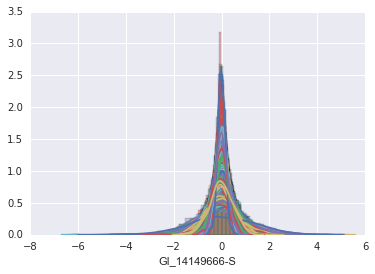

In [288]:
import seaborn as sns
for i in range(1, 600):
    sns.distplot(train_NA_as_mean[train_NA_as_mean.columns[i]]);

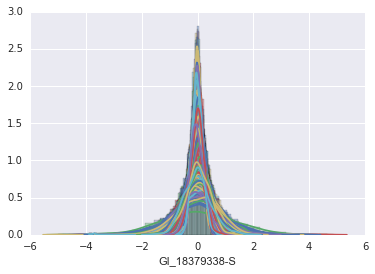

In [289]:
for i in range(600, 1200):
    sns.distplot(train_NA_as_mean[train_NA_as_mean.columns[i]]);

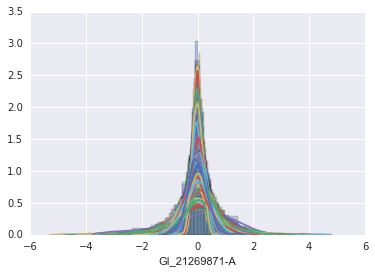

In [290]:
for i in range(1200, 1801):
    sns.distplot(train_NA_as_mean[train_NA_as_mean.columns[i]]);

We could see  feature has already been normalized with a mean around 0 

## Problem 1
Feature selection – part 1 – Random Forest (RF) based (20 pts)

Using the control data as the positive and negative training data (no test data) to build the following RFs, each of which has 500 trees. Compute the frequency of each gene appearing in each of the following RFs.


In [208]:
# This is the function to parse the feature frequency for the random forest model
# input: weka generated frequence files
# output: dictionary mapping each feature to its frequency
import re
import operator
def getFreq(filename):
    frequencies = {}
    with open(filename) as f:
        lines = f.readlines()
    r = re.compile(".*?\((.*?)\)")
    for line in lines:
        freq = int(r.match(line).group(1))
        feature = line.strip().split(')')[1]
        frequencies[feature] = freq
    return frequencies

### 1.1 Fix the number of features (genes) at 70% of the total number of features, vary the number of instances from 50% to 90%, with an increment of 5%; 


**Model Descirption**

For this part of homework, I used weka random forest model to fit the train data where the missing value were replaced with mean. In commond line of weka, **-P** means the percentage of instance we chose (varies in the following part of experiments), **-I** means number of trees we chose (500 trees), **-K** means the number of features we chose (70% of features, i.e. 1260 features). **-attribute-importance** is chosen to show feature frequency of the tree.

I did 5-fold cross validation to evaluate each model.

I have computed all the frequency for each feature for each model. However, for simplicity, I am going to show only top 15 genes selected by each model.

In [209]:
number_of_instances = [np.arange(0.5, 0.95, 0.05)]
number_of_instances

[array([ 0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ])]

### 1.1.1 percentage_of_instances = 0.5
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 50 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         255               70.0549 %
    * Incorrectly Classified Instances       109               29.9451 %
    * Kappa statistic                          0.3984
    * Mean absolute error                      0.4262
    * Root mean squared error                  0.4512
    * Relative absolute error                 85.3346 %
    * Root relative squared error             90.2846 %

In [210]:
# weka output file was "0.5i"
features_freq = getFreq("0.5i")
sorted_features_freq = sorted(features_freq.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq[0:15]

[('  GI_10047091-S', 219),
 ('  GI_14249537-S', 176),
 ('  GI_10047093-S', 144),
 ('  GI_10047103-S', 130),
 ('  GI_10047133-A', 120),
 ('  GI_20127596-S', 79),
 ('  GI_10092596-S', 77),
 ('  GI_10092616-S', 76),
 ('  GI_10092600-S', 73),
 ('  GI_10092618-S', 63),
 ('  GI_10092672-S', 56),
 ('  GI_10190745-S', 49),
 ('  GI_13375790-S', 48),
 ('  GI_10190705-S', 48),
 ('  GI_20127571-S', 44)]

### 1.1.2 percentage_of_instances = 0.55
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 55 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation
    * Correctly Classified Instances         250               68.6813 %
    * Incorrectly Classified Instances       114               31.3187 %
    * Kappa statistic                          0.3702
    * Mean absolute error                      0.4222
    * Root mean squared error                  0.4482
    * Relative absolute error                 84.5305 %
    * Root relative squared error             89.6854 %

In [291]:
# weka output file was "0.55i"
features_freq2 = getFreq("0.55i")
sorted_features_freq2 = sorted(features_freq2.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq2[0:15]

[('  GI_10047091-S', 227),
 ('  GI_14249537-S', 175),
 ('  GI_10047093-S', 160),
 ('  GI_10047103-S', 152),
 ('  GI_10047133-A', 124),
 ('  GI_10092596-S', 94),
 ('  GI_20127596-S', 84),
 ('  GI_10092600-S', 79),
 ('  GI_10092616-S', 64),
 ('  GI_10092672-S', 60),
 ('  GI_10092618-S', 57),
 ('  GI_21166356-S', 55),
 ('  GI_10518505-A', 51),
 ('  GI_13375790-S', 50),
 ('  GI_20127571-S', 45)]

### 1.1.3 percentage_of_instances = 0.6
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 60 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         254               69.7802 %
    * Incorrectly Classified Instances       110               30.2198 %
    * Kappa statistic                          0.3921
    * Mean absolute error                      0.423 
    * Root mean squared error                  0.4502
    * Relative absolute error                 84.679  %
    * Root relative squared error             90.0899 %

In [292]:
# weka output file was "0.6i"
features_freq3 = getFreq("0.6i")
sorted_features_freq3 = sorted(features_freq3.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq3[0:15]

[('  GI_10047091-S', 231),
 ('  GI_14249537-S', 217),
 ('  GI_10047093-S', 180),
 ('  GI_10047103-S', 163),
 ('  GI_10092596-S', 105),
 ('  GI_10047133-A', 104),
 ('  GI_20127596-S', 95),
 ('  GI_10092600-S', 81),
 ('  GI_10092616-S', 72),
 ('  GI_10092672-S', 69),
 ('  GI_10092618-S', 57),
 ('  GI_10190745-S', 57),
 ('  GI_10257436-S', 56),
 ('  GI_10190705-S', 52),
 ('  GI_13375790-S', 50)]

### 1.1.4 percentage_of_instances = 0.65
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 65 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation ===
    * Correctly Classified Instances         256               70.3297 %
    * Incorrectly Classified Instances       108               29.6703 %
    * Kappa statistic                          0.4034
    * Mean absolute error                      0.4203
    * Root mean squared error                  0.4471
    * Relative absolute error                 84.1488 %
    * Root relative squared error             89.4612 %

In [293]:
# weka output file was "0.65i"
features_freq4 = getFreq("0.65i")
sorted_features_freq4 = sorted(features_freq4.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq4[0:15]

[('  GI_10047091-S', 249),
 ('  GI_14249537-S', 210),
 ('  GI_10047093-S', 193),
 ('  GI_10047103-S', 177),
 ('  GI_10047133-A', 134),
 ('  GI_20127596-S', 116),
 ('  GI_10092596-S', 108),
 ('  GI_10092600-S', 83),
 ('  GI_10092672-S', 79),
 ('  GI_10092616-S', 77),
 ('  GI_21166356-S', 65),
 ('  GI_20127571-S', 57),
 ('  GI_10092618-S', 55),
 ('  GI_13375790-S', 54),
 ('  GI_10190745-S', 53)]

### 1.1.5 percentage_of_instances = 0.7
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 75 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         255               70.0549 %
    * Incorrectly Classified Instances       109               29.9451 %
    * Kappa statistic                          0.3986
    * Mean absolute error                      0.4208
    * Root mean squared error                  0.4486
    * Relative absolute error                 84.2555 %
    * Root relative squared error             89.7678 %

In [294]:
# weka output file was "0.7i"
features_freq5 = getFreq("0.7i")
sorted_features_freq5 = sorted(features_freq5.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq5[0:15]

[('  GI_10047091-S', 300),
 ('  GI_14249537-S', 228),
 ('  GI_10047093-S', 196),
 ('  GI_10047103-S', 187),
 ('  GI_10047133-A', 140),
 ('  GI_20127596-S', 136),
 ('  GI_10092596-S', 132),
 ('  GI_10092600-S', 107),
 ('  GI_10092616-S', 87),
 ('  GI_10092618-S', 75),
 ('  GI_10190745-S', 68),
 ('  GI_10092672-S', 66),
 ('  GI_21166356-S', 64),
 ('  GI_13375790-S', 62),
 ('  GI_20127571-S', 61)]

### 1.1.6 percentage_of_instances = 0.75
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 75 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         255               70.0549 %
    * Incorrectly Classified Instances       109               29.9451 %
    * Kappa statistic                          0.3977
    * Mean absolute error                      0.4186
    * Root mean squared error                  0.4476
    * Relative absolute error                 83.8099 %
    * Root relative squared error             89.5614 %

In [295]:
# weka output file was "0.75i"
features_freq6 = getFreq("0.75i")
sorted_features_freq6 = sorted(features_freq6.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq6[0:15]

[('  GI_10047091-S', 285),
 ('  GI_14249537-S', 241),
 ('  GI_10047093-S', 187),
 ('  GI_10047103-S', 185),
 ('  GI_20127596-S', 136),
 ('  GI_10092596-S', 116),
 ('  GI_10047133-A', 114),
 ('  GI_10092600-S', 104),
 ('  GI_10092616-S', 95),
 ('  GI_10092618-S', 80),
 ('  GI_21166356-S', 74),
 ('  GI_10092672-S', 68),
 ('  GI_20127571-S', 63),
 ('  GI_10440565-S', 61),
 ('  GI_13375790-S', 60)]

### 1.1.7 percentage_of_instances = 0.8
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 80 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2.  Stratified cross-validation 
    * Correctly Classified Instances         247               67.8571 %
    * Incorrectly Classified Instances       117               32.1429 %
    * Kappa statistic                          0.3545
    * Mean absolute error                      0.4191
    * Root mean squared error                  0.4485
    * Relative absolute error                 83.9144 %
    * Root relative squared error             89.7369 %

In [296]:
# weka output file was "0.8i"
features_freq7 = getFreq("0.8i")
sorted_features_freq7 = sorted(features_freq7.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq7[0:15]

[('  GI_10047091-S', 298),
 ('  GI_14249537-S', 248),
 ('  GI_10047093-S', 227),
 ('  GI_10047103-S', 187),
 ('  GI_20127596-S', 146),
 ('  GI_10047133-A', 146),
 ('  GI_10092596-S', 110),
 ('  GI_10092600-S', 97),
 ('  GI_10092672-S', 95),
 ('  GI_10092616-S', 94),
 ('  GI_21166356-S', 77),
 ('  GI_10092618-S', 76),
 ('  GI_13375790-S', 70),
 ('  GI_10518499-S', 69),
 ('  GI_10440565-S', 63)]

### 1.1.8 percentage_of_instances =0.85
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 85 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         254               69.7802 %
    * Incorrectly Classified Instances       110               30.2198 %
    * Kappa statistic                          0.393 
    * Mean absolute error                      0.4174
    * Root mean squared error                  0.447 
    * Relative absolute error                 83.5679 %
    * Root relative squared error             89.4377 %


In [297]:
# weka output file was "0.85i"
features_freq8 = getFreq("0.85i")
sorted_features_freq8 = sorted(features_freq8.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq8[0:15]

[('  GI_10047091-S', 331),
 ('  GI_10047093-S', 266),
 ('  GI_14249537-S', 256),
 ('  GI_10047103-S', 204),
 ('  GI_20127596-S', 164),
 ('  GI_10092596-S', 137),
 ('  GI_10047133-A', 121),
 ('  GI_10092600-S', 119),
 ('  GI_10092672-S', 105),
 ('  GI_10092618-S', 98),
 ('  GI_10092616-S', 90),
 ('  GI_21166356-S', 82),
 ('  GI_20127571-S', 66),
 ('  GI_13375790-S', 65),
 ('  GI_10190705-S', 64)]

### 1.1.9 percentage_of_instances = 0.9
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 90 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         253               69.5055 %
    * Incorrectly Classified Instances       111               30.4945 %
    * Kappa statistic                          0.3869
    * Mean absolute error                      0.4154
    * Root mean squared error                  0.4453
    * Relative absolute error                 83.1719 %
    * Root relative squared error             89.1129 %

In [298]:
# weka output file was "0.9i"
features_freq9 = getFreq("0.9i")
sorted_features_freq9 = sorted(features_freq9.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq9[0:15]

[('  GI_10047091-S', 321),
 ('  GI_14249537-S', 265),
 ('  GI_10047093-S', 236),
 ('  GI_10047103-S', 200),
 ('  GI_10047133-A', 181),
 ('  GI_20127596-S', 169),
 ('  GI_10092600-S', 140),
 ('  GI_10092596-S', 123),
 ('  GI_10092618-S', 91),
 ('  GI_10092616-S', 85),
 ('  GI_10092672-S', 82),
 ('  GI_21166356-S', 75),
 ('  GI_10440565-S', 74),
 ('  GI_13375790-S', 72),
 ('  GI_10190705-S', 71)]

### 1.2 Fix the number of instances at 70% of the total number of instances, vary the number of features (genes) from 50% to 90%, with an increment of 5%; 


**Model Descirption**

For this part of homework, I used weka random forest model to fit the train data where the missing value were replaced with mean. In commond line of weka, **-P** means the percentage of instance we chose (70% of instance), **-I** means number of trees we chose (500 trees), **-K** means the number of features we chose (varies in the following experiments). **-attribute-importance** is chosen to show feature frequency of the tree.

I did 5-fold cross validation to evaluate the models.
I have computed all the frequency for each feature for each model. However, for simplicity, I am going to show only top 15 genes selected by each model.

In [299]:
number_of_features = [np.arange(0.5, 0.95, 0.05) * 1800]
number_of_features

[array([  900.,   990.,  1080.,  1170.,  1260.,  1350.,  1440.,  1530.,
         1620.])]

### 1.2.1 number_of_features = 900

1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 900 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         257               70.6044 %
    * Incorrectly Classified Instances       107               29.3956 %
    * Kappa statistic                          0.4096
    * Mean absolute error                      0.4226
    * Root mean squared error                  0.448 
    * Relative absolute error                 84.6031 %
    * Root relative squared error             89.6556 %

In [300]:
# weka output file was "900f"
features_freq10 = getFreq("900f")
sorted_features_freq10 = sorted(features_freq10.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq10[0:15]

[('  GI_10047091-S', 188),
 ('  GI_14249537-S', 186),
 ('  GI_10047093-S', 180),
 ('  GI_10047103-S', 147),
 ('  GI_20127596-S', 128),
 ('  GI_10092596-S', 117),
 ('  GI_10047133-A', 104),
 ('  GI_10092600-S', 99),
 ('  GI_10092616-S', 88),
 ('  GI_10092618-S', 79),
 ('  GI_10440565-S', 68),
 ('  GI_10092672-S', 68),
 ('  GI_10190745-S', 67),
 ('  GI_13375790-S', 64),
 ('  GI_21166356-S', 53)]

### 1.2.2 number_of_features = 990
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 990 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation
    * Correctly Classified Instances         254               69.7802 %
    * Incorrectly Classified Instances       110               30.2198 %
    * Kappa statistic                          0.3934
    * Mean absolute error                      0.4212
    * Root mean squared error                  0.4484
    * Relative absolute error                 84.3358 %
    * Root relative squared error             89.7286 %

In [301]:
# weka output file was "990f"
features_freq11 = getFreq("990f")
sorted_features_freq11 = sorted(features_freq11.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq11[0:15]

[('  GI_10047091-S', 244),
 ('  GI_14249537-S', 191),
 ('  GI_10047093-S', 163),
 ('  GI_10047103-S', 137),
 ('  GI_10047133-A', 128),
 ('  GI_10092596-S', 114),
 ('  GI_20127596-S', 108),
 ('  GI_10092616-S', 78),
 ('  GI_10092618-S', 74),
 ('  GI_10190705-S', 71),
 ('  GI_10092672-S', 69),
 ('  GI_10092600-S', 67),
 ('  GI_13375790-S', 63),
 ('  GI_21166356-S', 63),
 ('  GI_10190745-S', 57)]

### 1.2.3 number_of_features = 1080
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1080 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation
    * Correctly Classified Instances         256               70.3297 %
    * Incorrectly Classified Instances       108               29.6703 %
    * Kappa statistic                          0.404
    * Mean absolute error                      0.4201
    * Root mean squared error                  0.447
    * Relative absolute error                 84.0993 %
    * Root relative squared error             89.4445 %

In [302]:
# weka output file was "1080f"
features_freq12 = getFreq("1080f")
sorted_features_freq12 = sorted(features_freq12.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq12[0:15]

[('  GI_10047091-S', 234),
 ('  GI_14249537-S', 213),
 ('  GI_10047093-S', 192),
 ('  GI_10047103-S', 161),
 ('  GI_20127596-S', 132),
 ('  GI_10047133-A', 118),
 ('  GI_10092596-S', 103),
 ('  GI_10092600-S', 103),
 ('  GI_10092672-S', 96),
 ('  GI_10092616-S', 93),
 ('  GI_13375790-S', 69),
 ('  GI_21166356-S', 69),
 ('  GI_10092618-S', 67),
 ('  GI_20127571-S', 64),
 ('  GI_10518499-S', 56)]

### 1.2.4 number_of_features = 1170
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1170 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation
    * Correctly Classified Instances         252               69.2308 %
    * Incorrectly Classified Instances       112               30.7692 %
    * Kappa statistic                          0.3822
    * Mean absolute error                      0.42
    * Root mean squared error                  0.4471
    * Relative absolute error                 84.0894 %
    * Root relative squared error             89.4576 %

In [303]:
# weka output file was "1170f"
features_freq13 = getFreq("1170f")
sorted_features_freq13 = sorted(features_freq13.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq13[0:15]

[('  GI_10047091-S', 265),
 ('  GI_14249537-S', 225),
 ('  GI_10047093-S', 193),
 ('  GI_10047103-S', 153),
 ('  GI_20127596-S', 125),
 ('  GI_10092596-S', 123),
 ('  GI_10092600-S', 106),
 ('  GI_10047133-A', 105),
 ('  GI_10092616-S', 89),
 ('  GI_10092672-S', 77),
 ('  GI_10092618-S', 69),
 ('  GI_21166356-S', 66),
 ('  GI_20127571-S', 65),
 ('  GI_10190745-S', 62),
 ('  GI_13375790-S', 61)]

### 1.2.5 number_of_features = 1260
1. run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1260 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         255               70.0549 %
    * Incorrectly Classified Instances       109               29.9451 %
    * Kappa statistic                          0.3986
    * Mean absolute error                      0.4208
    * Root mean squared error                  0.4486
    * Relative absolute error                 84.2555 %
    * Root relative squared error             89.7678 %

In [304]:
# weka output file was "1260f"
features_freq14 = getFreq("1260f")
sorted_features_freq14 = sorted(features_freq14.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq14[0:15]

[('  GI_10047091-S', 300),
 ('  GI_14249537-S', 228),
 ('  GI_10047093-S', 196),
 ('  GI_10047103-S', 187),
 ('  GI_10047133-A', 140),
 ('  GI_20127596-S', 136),
 ('  GI_10092596-S', 132),
 ('  GI_10092600-S', 107),
 ('  GI_10092616-S', 87),
 ('  GI_10092618-S', 75),
 ('  GI_10190745-S', 68),
 ('  GI_10092672-S', 66),
 ('  GI_21166356-S', 64),
 ('  GI_13375790-S', 62),
 ('  GI_20127571-S', 61)]

### 1.2.6 number_of_features = 1350
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1350 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         254               69.7802 %
    * Incorrectly Classified Instances       110               30.2198 %
    * Kappa statistic                          0.3936
    * Mean absolute error                      0.4194
    * Root mean squared error                  0.4474
    * Relative absolute error                 83.9606 %
    * Root relative squared error             89.5265 %

In [305]:
# weka output file was "1350f"
features_freq15 = getFreq("1350f")
sorted_features_freq15 = sorted(features_freq15.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq15[0:15]

[('  GI_10047091-S', 293),
 ('  GI_14249537-S', 242),
 ('  GI_10047093-S', 216),
 ('  GI_10047103-S', 180),
 ('  GI_10047133-A', 132),
 ('  GI_20127596-S', 125),
 ('  GI_10092596-S', 121),
 ('  GI_10092600-S', 94),
 ('  GI_10092616-S', 83),
 ('  GI_20127571-S', 71),
 ('  GI_10092672-S', 68),
 ('  GI_10190745-S', 64),
 ('  GI_10092618-S', 63),
 ('  GI_10257436-S', 59),
 ('  GI_10190705-S', 59)]

### 1.2.7 number_of_features = 1440
1. Run information
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1440 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         249               68.4066 %
    * Incorrectly Classified Instances       115               31.5934 %
    * Kappa statistic                          0.3659
    * Mean absolute error                      0.4184
    * Root mean squared error                  0.4473
    * Relative absolute error                 83.7769 %
    * Root relative squared error             89.5076 %

In [306]:
# weka output file was "1440f"
features_freq16 = getFreq("1440f")
sorted_features_freq16 = sorted(features_freq16.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq16[0:15]

[('  GI_10047091-S', 300),
 ('  GI_14249537-S', 245),
 ('  GI_10047093-S', 231),
 ('  GI_10047103-S', 185),
 ('  GI_20127596-S', 147),
 ('  GI_10092596-S', 137),
 ('  GI_10047133-A', 137),
 ('  GI_10092600-S', 109),
 ('  GI_10092616-S', 72),
 ('  GI_10092672-S', 69),
 ('  GI_20127571-S', 67),
 ('  GI_10092618-S', 65),
 ('  GI_21166356-S', 62),
 ('  GI_10440565-S', 55),
 ('  GI_13375790-S', 55)]

### 1.2.8 number_of_features = 1530
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1530 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         253               69.5055 %
    * Incorrectly Classified Instances       111               30.4945 %
    * Kappa statistic                          0.3873
    * Mean absolute error                      0.4178
    * Root mean squared error                  0.4468
    * Relative absolute error                 83.6383 %
    * Root relative squared error             89.4121 %

In [307]:
# weka output file was "1530f"
features_freq17 = getFreq("1530f")
sorted_features_freq17 = sorted(features_freq17.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq17[0:15]

[('  GI_10047091-S', 343),
 ('  GI_14249537-S', 256),
 ('  GI_10047093-S', 220),
 ('  GI_10047103-S', 196),
 ('  GI_20127596-S', 134),
 ('  GI_10047133-A', 130),
 ('  GI_10092596-S', 106),
 ('  GI_10092600-S', 96),
 ('  GI_10092672-S', 84),
 ('  GI_10092616-S', 77),
 ('  GI_10092618-S', 71),
 ('  GI_20127571-S', 67),
 ('  GI_21166356-S', 63),
 ('  GI_10518505-A', 59),
 ('  GI_10190745-S', 58)]

### 1.2.9 number_of_features = 1620
1. Run information 
    * Scheme:       weka.classifiers.trees.RandomForest -P 70 -attribute-importance -I 500 -num-slots 1 -K 1620 -M 1.0 -V 0.001 -S 1
    * Relation:     train_replaceNAwithMean-weka.filters.unsupervised.attribute.NumericToNominal-R1
    * Test mode:    5-fold cross-validation
2. Stratified cross-validation 
    * Correctly Classified Instances         251               68.956  %
    * Incorrectly Classified Instances       113               31.044  %
    * Kappa statistic                          0.3761
    * Mean absolute error                      0.4168
    * Root mean squared error                  0.4461
    * Relative absolute error                 83.4524 %
    * Root relative squared error             89.2695 %


In [308]:
# weka output file was "1620f"
features_freq18 = getFreq("1620f")
sorted_features_freq18 = sorted(features_freq18.items(), key=operator.itemgetter(1), reverse=True)
sorted_features_freq18[0:15]

[('  GI_10047091-S', 338),
 ('  GI_14249537-S', 261),
 ('  GI_10047093-S', 219),
 ('  GI_10047103-S', 157),
 ('  GI_20127596-S', 134),
 ('  GI_10092596-S', 128),
 ('  GI_10047133-A', 114),
 ('  GI_10092600-S', 89),
 ('  GI_10092616-S', 88),
 ('  GI_10092672-S', 80),
 ('  GI_20127571-S', 68),
 ('  GI_10190745-S', 68),
 ('  GI_21166356-S', 67),
 ('  GI_10092618-S', 66),
 ('  GI_13375790-S', 56)]

** Discussion **

We could see that the model accuracy didn't change much when we varying the number of features with fixed number of instances or varying the number of instances with fixed feature numbers, varying from 68% to 70%. And the most frequent features(top 15 genes) selected by different forests were very similar.

### 1.3 What does the frequency of a gene in a RF tell us about this gene for AD? 



Random forest tree algorithm is an implementation of bagging using decision tree as the base classifier. The beginning of random forest algorithm starts with randomly selecting “k” features out of total “m” features. In the next stage, we are using the randomly selected “k” features to find the root node by using the best split approach. We repeat the process until we form the tree with a root node and having the target as the leaf node. Finally, we repeat the tree building process to create “n” randomly created trees. These randomly created trees forms the random forest. Since we always picked the feature that gives us maximum information gain/gain ratio when buidling the tree. The frequently picked feature(gene) means the feature usually leads to best split. For a forest, the feature frequency would be the total frequencies of the features in all the trees and are ranked accordingly. Therefore, higher frequency in some sense means it's been picked many times for best split when building the tree, i.e., the feature(gene) is important in classifying the data.

### 1.4 how do we compare two genes based on their frequencies?
As explained in 1.3, the higher the frequency, the more important the feature is. However, consider a specific tree in forest, and consider the frequency of the features selected to split this tree, the frequency of these features should be the same as 1. But we know that the feature closer to root of the tree is more important than the feature on the lower layer of the tree, i.e., feature closer to root giving higher information gain. Therefore, if we only consider the frequency, it is not that accurate and complete. A much more commonly used way for feature selection is considering the Gini impurity or information gain/entropy of the feature. The higher the information gain, the more important the feature is.

### 1.5 Now the feature selection: Not all 8,000+ genes are important or useful. If you can only use a small number of genes, say 100, which ones do you use?



We have built 18 forest. And the top15 frequent features provided by different forest were very similar. Now Let's see how similar if considering top 100 genes.

In [309]:
# The function calculates the number of different features in two set of frequencies considering top n selected features
def numberOfDifference(freq1, freq2, n):
    top1 = [feature for feature, value in freq1[0:n]]
    top2 = [feature for feature, value in freq2[0:n]]
    return len([feature for feature in top1 if feature not in top2])

In [310]:
all_feature_freqs = [sorted_features_freq1,sorted_features_freq2, sorted_features_freq3, sorted_features_freq4, sorted_features_freq5, sorted_features_freq6, sorted_features_freq7, sorted_features_freq8, sorted_features_freq9, sorted_features_freq10,sorted_features_freq11,sorted_features_freq12, sorted_features_freq13,sorted_features_freq14, sorted_features_freq15,sorted_features_freq16,sorted_features_freq17,sorted_features_freq18]

In [311]:
# getDifference returns a list,
# each element represents the number of different features in any 2 sets of frequencies among 18 forest considering top n genes
def getDifference(all_feature_freqs, n):
    diff = []
    for i in range(len(all_feature_freqs)-1):
        for j in range(i+1, len(all_feature_freqs)):
            diff.append(numberOfDifference(all_feature_freqs[i], all_feature_freqs[j], n))
            #print  i+1 , "," , j+1 , ": " , numberOfDifference(all_feature_freqs[i], all_feature_freqs[j])
    return diff

In [312]:
top100_diff = getDifference(all_feature_freqs, 100)

In [313]:
max(top100_diff)

38

We built our models only on the first 1800 genes. Therefore, I am going to select the top 100 genes from these genes. From above study, we can see that the top100 genes selected by each model are at most off by 37 genes, which is fairly large. Therefore I am going to report the top 100 genes based on the most accurate random forest model. Among 18 random forest we built in 1.1 and 1.2, the highest accuaracy we got is 70.6044 %, it is the model when we choose 70% of instance and 900 features (50% of features). 

In [314]:
# frequencies from the model using 70% instance and 50% features
top100_based_on_forest = sorted_features_freq10[0:100]
top100_based_on_forest

[('  GI_10047091-S', 188),
 ('  GI_14249537-S', 186),
 ('  GI_10047093-S', 180),
 ('  GI_10047103-S', 147),
 ('  GI_20127596-S', 128),
 ('  GI_10092596-S', 117),
 ('  GI_10047133-A', 104),
 ('  GI_10092600-S', 99),
 ('  GI_10092616-S', 88),
 ('  GI_10092618-S', 79),
 ('  GI_10440565-S', 68),
 ('  GI_10092672-S', 68),
 ('  GI_10190745-S', 67),
 ('  GI_13375790-S', 64),
 ('  GI_21166356-S', 53),
 ('  GI_10190705-S', 49),
 ('  GI_10257436-S', 48),
 ('  GI_10346134-S', 47),
 ('  GI_20127571-S', 45),
 ('  GI_10518499-S', 45),
 ('  GI_10518505-A', 42),
 ('  GI_10337596-S', 42),
 ('  GI_10518505-I', 40),
 ('  GI_14249161-S', 36),
 ('  GI_10835100-S', 36),
 ('  GI_10442821-S', 34),
 ('  GI_10518498-S', 33),
 ('  GI_10518496-S', 30),
 ('  GI_13899314-S', 30),
 ('  GI_10800147-S', 30),
 ('  GI_16936521-S', 29),
 ('  GI_14149858-S', 29),
 ('  GI_10800418-S', 27),
 ('  GI_10834965-S', 25),
 ('  GI_10835229-S', 24),
 ('  GI_10835070-S', 24),
 ('  GI_10863878-S', 24),
 ('  GI_11321616-S', 23),
 ('  

### 1.6 (not required, but if you do it correctly or in a meaningful way, you get 5 bonus points) Are the orderings of the genes using the RF method stable?  What factors affect the stability? How can we quantify the stability? 


For the experiments we have done, we could see that the orderings of the genes are quite stable. That is due to we built our forest from 500 trees with at least 50% features and 50% instances. This ensures that almost all the features and instances have been covered in the process of buidling the forest. And since we have a large number of tree, the avargeing result of the trees shows a quite stable ordering. 

Therefore, we could see that the stability dependends on the number of trees, the percentage of features as well as the percentage of instances. With two of the parameters fixed, we could test on the effect of the third parameter. Firstly, if we build the forest only on a small number of trees, some important features and instances may not be selected, which leads to variance of orderings of the genes. Secondly, if we select a very small number of features, say 5%, again, some important features may not be selected, leading to different results between different forests. Thirdly, if we select a very small number of instances, say 1%, it may gives us quite baised tree considering such small number of instance, leading to different orderings. Therefore, if the number of trees, percentage of features, and percentage of instances are large enough, we shall see very stable result for the orderings of the genes, since the random forest provides the averaging result of all the trees and the tree always pick the feature that gives max information gain for the best split.

To quantify the stability, we could fix two of the three parameters, and try a range of the third parameter to see when the forest starts generating the stable result.

## Problem 2
Feature selection – part 2 – SVM (20 pts)

Recall that the maximal margin classifier of SVM is f(x) = (wTv+b), where vector w and scalar b are the parameters of the SVM model learned from the training data (in this case, the data are the data for the AD cases and normal controls combined).  We now use the following kernels to build SVM models for AD


**Model Descirption**

For this part of homework, I used weka SMO(SVM) model to fit the train data where the missing value were replaced with mean. In commond line of weka, **-E** means the degree of the polynomial kernel (when E set as 1, it is a linear kernel, when E set as 2, it is a quadratic kernel), **-L** means if we use the lower order term (if -L is chosen, we includes b or 1 in the linear kernel or quadratic kernel respectively). 

I did 5-fold cross validation to evaluate the models.

**Note**
If we take a close look at the data, we shall see each feature has already been normalized with a mean around 0 (Please see data preprocessing part) Therefore, I chose "no normalization" when I fit SVM model to the dataset. And if we compare the result between "normalize" and "no normalize", I saw "no normalize"(accuracy around 60%) gave higher accuracy than "normalize"(accuracy around 40%) (data not shown).

### 2.1 Linear kernel: k(x, x’) = (x<sup>T</sup>x’), whose model is simply f(x) = (w<sup>T</sup>x+b);


1. Run information 
   * Scheme:       weka.classifiers.functions.SMO -C 1.0 -L 0.001 -P 1.0E-12 -N 2 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.PolyKernel -E 1.0 -L -C 250007" -calibrator
   * "weka.classifiers.functions.Logistic -R 1.0E-8 -M -1 -num-decimal-places 4"
   * Test mode:    5-fold cross-validation

2. Classifier model (full training set) 
    * SMO
    * Kernel used: Linear Kernel with lower order: K(x,y) = < x,y > + 1
    * Classifier for classes: 1, 2
    
3. Stratified cross-validation 
    * Correctly Classified Instances         170               46.7033 %
    * Incorrectly Classified Instances       194               53.2967 %
    * Kappa statistic                         -0.078 
    * Mean absolute error                      0.533 
    * Root mean squared error                  0.73  
    * Relative absolute error                106.7054 %
    * Root relative squared error            146.0837 %

### 2.2 Homogeneous quadratic kernel: k(x, x’) = (x<sup>T</sup>x’)<sup>2</sup>
1. Run information
   * Scheme:       weka.classifiers.functions.SMO -C 1.0 -L 0.001 -P 1.0E-12 -N 2 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.PolyKernel -E 2.0 -C 250007" -calibrator
   * "weka.classifiers.functions.Logistic -R 1.0E-8 -M -1 -num-decimal-places 4"
   * Test mode:    5-fold cross-validation
2. Classifier model (full training set) 
    * SMO
    * Kernel used: Poly Kernel: K(x,y) = < x,y >^2.0
    * Classifier for classes: 1, 2
3. Stratified cross-validation 
   * Correctly Classified Instances         225               61.8132 %
    * Incorrectly Classified Instances       139               38.1868 %
    * Kappa statistic                          0.2308
    * Mean absolute error                      0.3819
    * Root mean squared error                  0.618 
    * Relative absolute error                 76.4539 %
    * Root relative squared error            123.654  %

### 2.3 Inhomogeneous quadratic kernel: k(x, x’) = (x<sup>T</sup>x’+1)<sup>2</sup>.
1. Run information 
    * Scheme:       weka.classifiers.functions.SMO -C 1.0 -L 0.001 -P 1.0E-12 -N 2 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.PolyKernel -E 2.0 -L -C 250007" -calibrator 
    * "weka.classifiers.functions.Logistic -R 1.0E-8 -M -1 -num-decimal-places 4"
    * Test mode:    5-fold cross-validation

2. Classifier model (full training set) 
    * SMO

    * Kernel used: Poly Kernel with lower order: K(x,y) = (< x,y > + 1)^2.0

    * Classifier for classes: 1, 2
3. Stratified cross-validation
    * Correctly Classified Instances         234               64.2857 %
    * Incorrectly Classified Instances       130               35.7143 %
    * Kappa statistic                          0.2805
    * Mean absolute error                      0.3571
    * Root mean squared error                  0.5976
    * Relative absolute error                 71.5036 %
    * Root relative squared error            119.5839 %

### 2.4 Given an SVM model f(x) = (w<sup>T</sup>v+b), i.e., w and b are given, what do the values in vector w tell us about individual dimensions (features)? Hint: how can we compare the importance of two features? 



After fitting SVM model, each feature will be assigned a weight value indicating its importance. The absolute value of the weight indicates how important the feature is, i.e., the higher the absolute the value of the weight, the more important the feature is.

In [315]:
# This is the function to parse weights after fitting SVM linear kernel
# input: weka generated frequence files
# output: dictionary mapping each feature to its weight
import math
def getWeights(filename):
    weights = {}
    with open(filename) as f:
        lines = f.readlines()
    for line in lines[:-1]:
        feature = line.strip().split()[4]
        # take absolute value of the weights
        weight = abs(float(line.strip().split()[1]))
        weights[feature] = weight
    return weights

In [316]:
weights = getWeights("linearSVM")
sorted_weights = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
sorted_weights[0:15]

[('GI_15967158-A', 0.8766),
 ('GI_19923365-S', 0.7224),
 ('GI_13375757-S', 0.6191),
 ('GI_20070278-S', 0.594),
 ('GI_10835229-S', 0.5828),
 ('GI_16936521-S', 0.5806),
 ('GI_14249315-S', 0.5698),
 ('GI_16306593-I', 0.5566),
 ('GI_14589875-A', 0.5529),
 ('GI_16506819-S', 0.5498),
 ('GI_21264595-A', 0.5493),
 ('GI_10835100-S', 0.5475),
 ('GI_13430867-S', 0.5243),
 ('GI_16507197-S', 0.5241),
 ('GI_11968050-S', 0.5237)]

### 2.5	With the linear kernel, how should we select the top features? Your answer gives rise to a feature selection method. Now choose the top 100 genes using your method and compare them with the result from P2(4) above.



We can choose the top 100 genes that have the highest 100 absolute weight values, which is shown in the following code block. 

In [317]:
top100_genes_based_on_weights = sorted_weights[0:100]
top100_genes_based_on_weights

[('GI_15967158-A', 0.8766),
 ('GI_19923365-S', 0.7224),
 ('GI_13375757-S', 0.6191),
 ('GI_20070278-S', 0.594),
 ('GI_10835229-S', 0.5828),
 ('GI_16936521-S', 0.5806),
 ('GI_14249315-S', 0.5698),
 ('GI_16306593-I', 0.5566),
 ('GI_14589875-A', 0.5529),
 ('GI_16506819-S', 0.5498),
 ('GI_21264595-A', 0.5493),
 ('GI_10835100-S', 0.5475),
 ('GI_13430867-S', 0.5243),
 ('GI_16507197-S', 0.5241),
 ('GI_11968050-S', 0.5237),
 ('GI_14702170-I', 0.5219),
 ('GI_14249449-S', 0.5125),
 ('GI_13375845-S', 0.5079),
 ('GI_20270388-S', 0.503),
 ('GI_19557644-S', 0.4923),
 ('GI_11140810-S', 0.4921),
 ('GI_21071059-S', 0.4893),
 ('GI_11119413-S', 0.4866),
 ('GI_11184225-S', 0.4848),
 ('GI_16950596-A', 0.4737),
 ('GI_18640747-S', 0.471),
 ('GI_14150057-S', 0.47),
 ('GI_16933541-I', 0.4634),
 ('GI_16905502-A', 0.4627),
 ('GI_14249125-S', 0.4595),
 ('GI_16936531-I', 0.4565),
 ('GI_13376229-S', 0.4549),
 ('GI_14277673-S', 0.4542),
 ('GI_14141173-S', 0.4539),
 ('GI_20127606-S', 0.4532),
 ('GI_13514821-A', 0.4529

In [318]:
# This is the function to parse the feature frequency from the random forest model
# input: weka generated frequence files using random forest model
# output: dictionary mapping each feature to its frequency
import re
import operator
def getTuple(filename):
    frequencies = []
    with open(filename) as f:
        lines = f.readlines()
    r = re.compile(".*?\((.*?)\)")
    for line in lines:
        freq = int(r.match(line).group(1))
        feature = line.strip().split(')')[1]
        frequencies.append((feature, freq) )
    return frequencies

In [319]:
#random forest genes frequencies with 900 features and 70% instance and 500 trees
frequencies_based_on_forest = getTuple('900f')

In [320]:
numberOfDifference(top100_based_on_forest, top100_genes_based_on_weights,100)

100

The top 100 genes selected by feature frequency of random forest and weight information of SVM are totally different...

There are two factors we could consider here. Firstly, SVM with linear kernel model gave us only 46.7% accuracy, meaning the model performed pretty bad on our dataset, which could lead to bad feature selection. Secondly, from part1, we discussed that it is not accurate to select top 100 genes only based on frequencies. A much better way is to consider the "feature importance", which are usually given as max information gain/entropy parameters in the model.

### 2.6	Which of the two quadratic kernels is better for feature selection and why?

From lecture slides, we know that

Homogenous kernel: $\varphi$(x) = (x<sub>1</sub><sup>2</sup> , x<sub>2</sub><sup>2</sup> , $\sqrt{2}$x<sub>1</sub>x<sub>2</sub>)

Inhomogenous kernel: $\varphi$(x) = (x<sub>1</sub><sup>2</sup> , x<sub>2</sub><sup>2</sup> , $\sqrt{2}$x<sub>1</sub>x<sub>2</sub> ,$\sqrt{2}$x<sub>1</sub>, $\sqrt{2}$x<sub>2</sub>)

Here we could see that inhomogenous kernel has two more lower terms compared with homogenous kernel. Therefore, theorectically, its performance should be better. 

This is consistent with our experimental analysis, where the inhomogenous kernel showed an accuracy of 64.3% whereas homogenous kernel showed an accuracy of 61.8%. Since inhomogenous kernel has better accuracy, it would be a better choice for feature selection.

### 2.7 With the two quadratic kernels, can we find correlated features (genes)?  Why? 


Yes, we could find the correlated features.

In both kernels, the number of support vectors is 319. The output is a weighed combination of kernel evaluations involving the support vectors (shown in <>) and a test point X. In order to find the correlated features, we need to take a look at the weights for $\sqrt{2}$x<sub>1</sub>x<sub>2</sub> term. We will use a homogenous kernel for example.

Consider a small example where we have 3 features(genes) {x1,x2,x3} for each data point; after mapping to feature space, for each data point we will have

< x<sub>1</sub><sup>2</sup> , x<sub>2</sub><sup>2</sup> , x<sub>3</sub><sup>2</sup> , $\sqrt{2}$x<sub>1</sub>x<sub>2</sub>, $\sqrt{2}$x<sub>1</sub>x<sub>3</sub>, $\sqrt{2}$x<sub>2</sub>x<sub>3</sub>  >

Now each data point wil have six features.


After calculation, we will get weight factors for x<sub>1</sub>x<sub>2</sub>, x<sub>1</sub>x<sub>3</sub>, x<sub>2</sub>x<sub>3</sub> terms seperately. Suppose they are w1, w2, w3 seperately. 

To see if x1 and x2 correlated, we need to see if w1/(w1 + w2 + w3) large enough.

To see if x2 and x3 correlated, we need to see if w3/(w1 + w2 + w3) large enough.

To see if x1 and x3 correlated, we need to see if w2/(w1 + w2 + w3) large enough.